# Simulating diffusion with the Langevin equation
## Nikolas Schnellbächer
### last updated 2018-05-27

In [283]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import scipy

In [284]:
# fix random number seed for reproducibility
# np.random.seed(123456789)

In [285]:
def LangevinPropagator_vectorized(sampleTimes, m, a = 0.0, 
                                  sigma = 1.0, dt = 1.0e-3, 
                                  x0 = 0.0):
    '''
    Vectorized version of the LangevinPropagator function, making use of
    numpy's vectorization possibilities.
    '''
    nSamples = len(sampleTimes)
    iterations = (sampleTimes / dt).astype(int)        
    iterations[1:] = iterations[1:] - iterations[0:-1]
    totalIterations = (np.cumsum(iterations))[-1]
        
    # make sure that the noise amplitude is calculated outside the
    # for loops below to save computation time
    # square roots are numerically quite expensive   
    noise = sigma * np.sqrt(2.0 * dt) # noise amplitude
    drift = a * dt
    
    out = np.zeros((nSamples, m))
    
    X = x0 * np.ones((1, m)) # row element
    
    for k in range(nSamples):
        
        for i in range(iterations[k]):
        
            X += drift * X + noise * np.random.normal(0.0, 1.0, m)
        
        out[k, :] = X
    
    return out

def LangevinPropagatorReflectiveBC_vectorized(sampleTimes, m, a = 0.0, 
                                              sigma = 1.0, dt = 1.0e-3, 
                                              x0 = 2.0):
    
    nSamples = len(sampleTimes)
    iterations = (sampleTimes / dt).astype(int)        
    iterations[1:] = iterations[1:] - iterations[0:-1]
    totalIterations = (np.cumsum(iterations))[-1]
        
    # make sure that the noise amplitude is calculated outside the
    # for loops below to save computation time
    # square roots are numerically quite expensive   
    noise = sigma * np.sqrt(2.0 * dt) # noise amplitude
    
    out = np.zeros((nSamples, m))
    
    X = x0 * np.ones((1, m))
    
    for k in range(nSamples):
            
        for i in range(iterations[k]):
            
            X += noise * np.random.normal(0.0, 1.0, m)
            
            # reflective boundary condition at x = 0.0
            mask = np.argwhere(X < 0.0)
            X[0, mask] = -1.0 * X[0, mask]
                
        out[k, :] = X
     
    return out

def LangevinPropagatorReflectiveBC_overshoot_vectorized(sampleTimes, \
    m, a = 0.0, sigma = 1.0, dt = 1.0e-3, x0 = 2.0):
    
    nSamples = len(sampleTimes)
    iterations = (sampleTimes / dt).astype(int)        
    iterations[1:] = iterations[1:] - iterations[0:-1]
    totalIterations = (np.cumsum(iterations))[-1]
        
    # make sure that the noise amplitude is calculated outside the
    # for loops below to save computation time
    # square roots are numerically quite expensive   
    noise = sigma * np.sqrt(2.0 * dt) # noise amplitude
    
    out = np.zeros((nSamples, m))
    
    X = x0 * np.ones((1, m))
    
    for k in range(nSamples):
            
        for i in range(iterations[k]):
            
            X += noise * np.random.normal(0.0, 1.0, m)
            
            # reflective boundary condition at x = 0.0
            mask = np.argwhere(X < 0.0)
            X[0, mask] = 0.0
                
        out[k, :] = X
     
    return out

def getMoments(X):
    '''
    Computes the first moments and the MSD of a given set of trajectories.
    '''
    mu = np.mean(X, axis = 1)
    MSD = np.zeros((X.shape[0],))
    for i in range(X.shape[0]):
        MSD[i] = np.mean(np.square((X[i, : ] - mu[i])))
        
    return mu, MSD

In [286]:
def Mean_ReflectiveBC(t, x0):
    tmp = np.exp(-x0 ** 2 / (4.0 * t)) * np.sqrt(4.0 * t / np.pi)
    return tmp + x0 * scipy.special.erf(x0 / np.sqrt(4.0 * t))

def MSD_ReflectiveBC(t, x0):
    c = 4.0 * t
    tmp = 2.0 * t + x0 ** 2
    tmp -= (2.0 * np.exp(- x0 ** 2 / c) * np.sqrt(t/np.pi) + x0 * \
           scipy.special.erf(x0 / (2.0 * np.sqrt(t))) ) ** 2
    return tmp

In [287]:
def plotPositionPDF_free(X, t, D = 1.0, x0 = 0.0):
    f, ax = plt.subplots(1)
    f.set_size_inches(5.0, 3.5)

    labelfontsize = 10.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    
    plt.hist(X, density = True, bins = 15)
    
    xVals = np.linspace(-12.0, 12.0, 500)
    yVals = stats.norm.pdf(xVals, x0, np.sqrt(2.0 * D * t))
    labelString = r'$p(x,t = %.1f)$' %(t)
    ax.plot(xVals, yVals, lw = 2.0, color = 'C3', label = labelString)
    
    ax.set_xlabel('position $x$', fontsize = 18)
    ax.set_ylabel(r'$p(x,t|x_0, t_0)$', fontsize = 18)
    
    ax.set_xlim(-10.5, 10.5)
    ax.set_ylim(0.0, 0.41)

    leg = ax.legend(fontsize = 12)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    
    return None

def plotPositionPDF_lrBC(X, t, D = 1.0, x0 = 0.0):
    f, ax = plt.subplots(1)
    f.set_size_inches(5.0, 3.5)

    labelfontsize = 10.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    
    plt.hist(X, density = True, bins = 15)
    
    xVals = np.linspace(0.0, 14.0, 500)
    yVals = stats.norm.pdf(xVals, x0, np.sqrt(2.0 * D * t)) + \
            stats.norm.pdf(-xVals, x0, np.sqrt(2.0 * D * t))
    labelString = r'$p(x,t = %.1f)$' %(t)
    ax.plot(xVals, yVals, lw = 2.0, color = 'C3', label = labelString)
    
    ax.set_xlabel('position $x$', fontsize = 18)
    ax.set_ylabel(r'$p(x,t|x_0, t_0)$', fontsize = 18)
    
    ax.set_xlim(0.0, 12.25)
    ax.set_ylim(0.0, 0.41)

    leg = ax.legend(fontsize = 12)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    
    return None

def plotFirstMoments(X, Y, x0 = 0.0):
    
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)
    
    ax.set_xlabel('time $t$', fontsize = 18)
    ax.set_ylabel(r'first moment $\langle x \rangle(t)$', fontsize = 18)
    labelfontsize = 15.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
        
    ax.plot([-2.0, 12.0], [x0, x0], 
            dashes = [8.0, 5.0], 
            lw = 0.5, 
            color = 'k', 
            label = r'$x = x_0$')
    ax.scatter(X, Y, color = 'k', s = 45)

    ax.set_xlim(-0.5, 11.2)
    ax.set_ylim(1.45, 2.55)
    
    leg = ax.legend(scatterpoints = 1,
                     markerscale = 1.0,
                     ncol = 1,
                     fontsize = 18)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    return None

def plotMSD(X, Y, t, D = 1.0):
    
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)
    
    ax.set_xlabel('time $t$', fontsize = 18)
    ax.set_ylabel(r'MSD(t)', fontsize = 18)
    labelfontsize = 15.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
        
    ax.plot([-2.0, 12.0], [2.0 * D * (-2.0), 2.0 * D * (12.0)], 
            lw = 1.0, color = 'C3', label = r'MSD(t) = 2Dt')
    ax.scatter(X, Y, color = 'k', s = 45, label = r'BD (numeric)')

    ax.set_xlim(-0.5, 11.2)
    ax.set_ylim(-1.0, 22.5)
    
    leg = ax.legend(scatterpoints = 1,
                     markerscale = 1.0,
                     ncol = 1,
                     fontsize = 18)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    return None

## Simulate free diffusion trajectories in one dimension

In [288]:
# set simulation parameters here
D = 1.0
dt = 1.0e-3
x0 = 2.0
sampleTimes = np.array([0.5 , 1.0, 3.0, 5.0, 10.0])
m = 10000

In [289]:
%%time
X = LangevinPropagator_vectorized(sampleTimes = sampleTimes, 
                                  m = m,
                                  x0 = x0)

CPU times: user 5.52 s, sys: 36.2 ms, total: 5.55 s
Wall time: 5.66 s


In [290]:
print(X.shape)

(5, 10000)


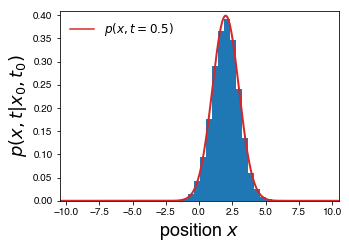

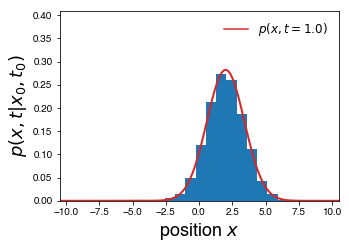

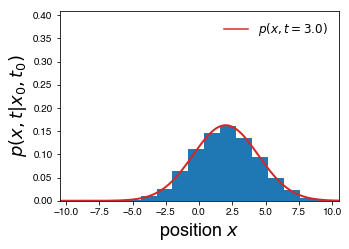

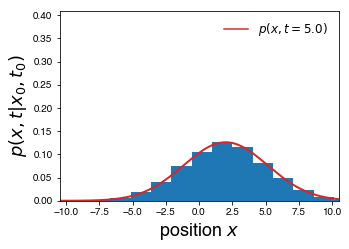

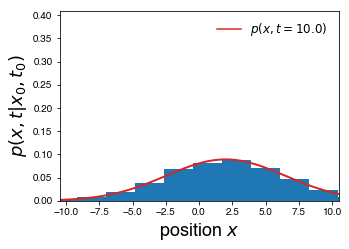

In [291]:
plotPositionPDF_free(X[0, :], 0.5, x0 = x0)
plotPositionPDF_free(X[1, :], 1.0, x0 = x0)
plotPositionPDF_free(X[2, :], 3.0, x0 = x0)
plotPositionPDF_free(X[3, :], 5.0, x0 = x0)
plotPositionPDF_free(X[4, :], 10.0, x0 = x0)

In [292]:
# compute the first moments and the MSD for the trajectories stored in X
mu, MSD = getMoments(X)

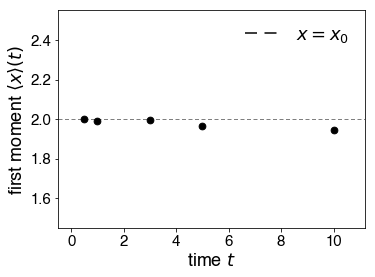

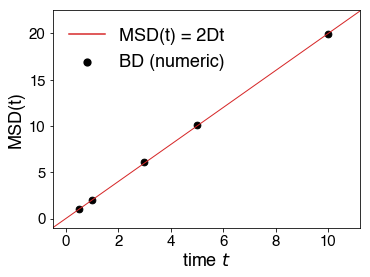

In [293]:
plotFirstMoments(sampleTimes, mu, x0 = x0)
plotMSD(sampleTimes, MSD, 1.0, D)

## Diffusion with a reflecting boundary to the left

In [294]:
%%time
Xl = LangevinPropagatorReflectiveBC_vectorized(sampleTimes = sampleTimes, 
                                               m = m,
                                               x0 = x0)

CPU times: user 6.04 s, sys: 53.5 ms, total: 6.1 s
Wall time: 6.28 s


In [296]:
print(Xl.shape)

(5, 10000)


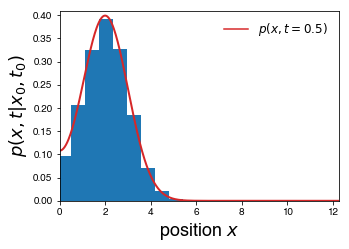

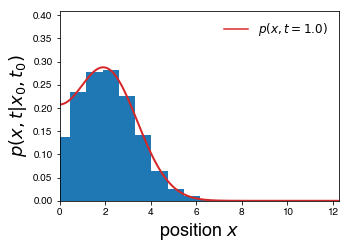

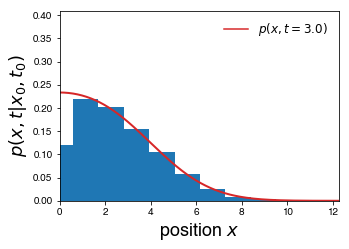

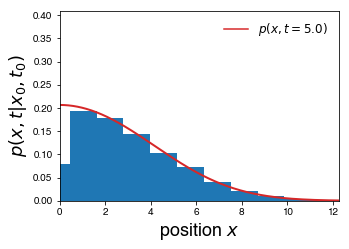

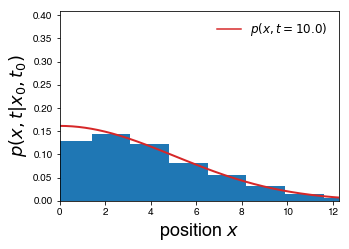

In [297]:
plotPositionPDF_lrBC(Xl[0, :], 0.5, x0 = x0)
plotPositionPDF_lrBC(Xl[1, :], 1.0, x0 = x0)
plotPositionPDF_lrBC(Xl[2, :], 3.0, x0 = x0)
plotPositionPDF_lrBC(Xl[3, :], 5.0, x0 = x0)
plotPositionPDF_lrBC(Xl[4, :], 10.0, x0 = x0)

In [298]:
# compute the first moments and the MSD for the trajectories stored in X
mul, MSDl = getMoments(Xl)

In [299]:
def plotFirstMoments_reflective(X, Y, x0 = 0.0):
    
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)
    
    ax.set_xlabel('time $t$', fontsize = 18)
    ax.set_ylabel(r'first moment $\langle x \rangle(t)$', fontsize = 18)
    labelfontsize = 15.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
        
    ax.plot([-2.0, 12.0], [x0, x0], 
            dashes = [8.0, 5.0], 
            lw = 0.5, 
            color = 'k', 
            label = r'$x = x_0$')
    
    xVals = np.linspace(0.0001, 12.0, 1000)
    yVals = np.array([Mean_ReflectiveBC(t, x0) for t in xVals])
    ax.plot(xVals, yVals, 
            lw = 1.0, color = 'C0', label = r'$\langle x \rangle(t)$')
    
    ax.scatter(X, Y, color = 'k', s = 45)

    ax.set_xlim(-0.5, 11.2)
    ax.set_ylim(1.85, 4.15)
    
    leg = ax.legend(scatterpoints = 1,
                     markerscale = 1.0,
                     ncol = 1,
                     fontsize = 18)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    return None

def plotMSD_reflective(X, Y, t, D = 1.0):
    
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)
    
    ax.set_xlabel('time $t$', fontsize = 18)
    ax.set_ylabel(r'MSD(t)', fontsize = 18)
    labelfontsize = 15.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
        
    ax.plot([-2.0, 12.0], [2.0 * D * (-2.0), 2.0 * D * (12.0)], 
            lw = 1.0, color = 'C3', label = r'$\sim 2Dt$',
           dashes = [8.0, 5.0])
    
    xVals = np.linspace(0.0001, 12.0, 1000)
    yVals = np.array([MSD_ReflectiveBC(t, x0) for t in xVals])
    ax.plot(xVals, yVals, 
            lw = 1.0, color = 'C3', label = r'MSD(t)')
    
    ax.scatter(X, Y, color = 'k', s = 45, label = r'BD (numeric)')

    ax.set_xlim(-0.5, 11.2)
    ax.set_ylim(-1.0, 22.5)
    
    leg = ax.legend(loc = 'upper left',
                    scatterpoints = 1,
                    markerscale = 1.0,
                    handlelength = 1.65,
                    ncol = 1,
                    fontsize = 18)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    return None

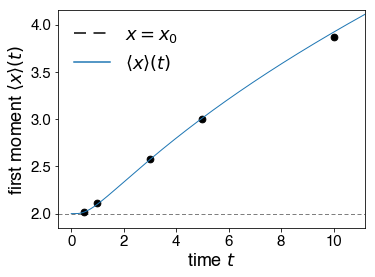

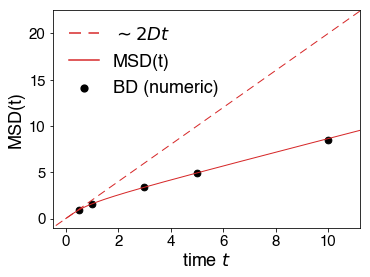

In [255]:
plotFirstMoments_reflective(sampleTimes, mul, x0 = x0)
plotMSD_reflective(sampleTimes, MSDl, 1.0, D)

In [300]:
%%time
m = 20000
Xl_over = LangevinPropagatorReflectiveBC_overshoot_vectorized(\
            sampleTimes = sampleTimes, 
            m = m,
            x0 = x0,
            dt = 1.0e-1)

CPU times: user 155 ms, sys: 4.72 ms, total: 160 ms
Wall time: 173 ms


In [301]:
print(Xl_over.shape)

(5, 20000)


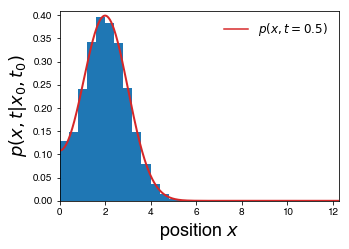

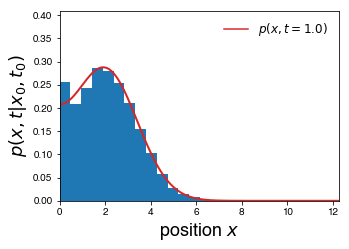

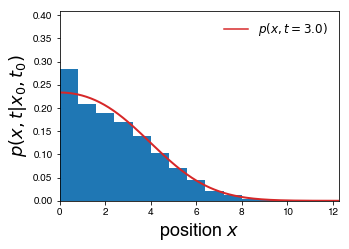

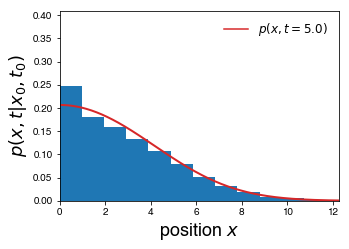

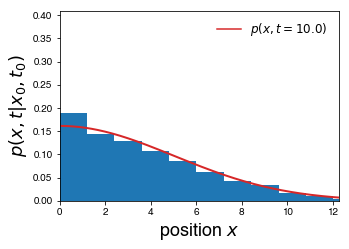

In [302]:
plotPositionPDF_lrBC(Xl_over[0, :], 0.5, x0 = x0)
plotPositionPDF_lrBC(Xl_over[1, :], 1.0, x0 = x0)
plotPositionPDF_lrBC(Xl_over[2, :], 3.0, x0 = x0)
plotPositionPDF_lrBC(Xl_over[3, :], 5.0, x0 = x0)
plotPositionPDF_lrBC(Xl_over[4, :], 10.0, x0 = x0)

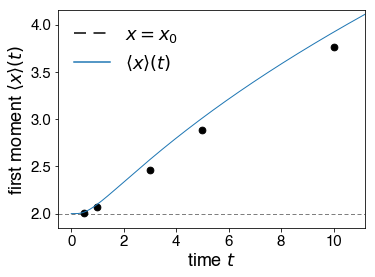

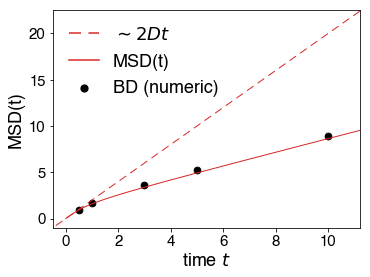

In [303]:
# compute the first moments and the MSD for the trajectories stored in X
mul, MSDl = getMoments(Xl_over)

plotFirstMoments_reflective(sampleTimes, mul, x0 = x0)
plotMSD_reflective(sampleTimes, MSDl, 1.0, D)

## Diffusion in a harmonic potential

In [304]:
x0 = 2.0
m = 10000

In [305]:
%%time
Xh = LangevinPropagator_vectorized(sampleTimes = sampleTimes, 
                                   m = m,
                                   x0 = x0,
                                   a = -1.0)

CPU times: user 5.22 s, sys: 43.6 ms, total: 5.26 s
Wall time: 5.34 s


In [306]:
print(Xh.shape)

(5, 10000)


In [307]:
def plotPositionPDF_harmonic(X, t, D = 1.0, x0 = 0.0):
    f, ax = plt.subplots(1)
    f.set_size_inches(5.0, 3.5)

    labelfontsize = 10.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    
    plt.hist(X, density = True, bins = 15)
    
    xVals = np.linspace(-12.0, 12.0, 500)
    yVals = stats.norm.pdf(xVals, \
        x0 * np.exp(-t), np.sqrt(D * (1.0 - np.exp(-2.0 * t))))
    labelString = r'$p(x,t = %.1f)$' %(t)
    ax.plot(xVals, yVals, lw = 2.0, color = 'C3', label = labelString)
    
    ax.set_xlabel('position $x$', fontsize = 18)
    ax.set_ylabel(r'$p(x,t|x_0, t_0)$', fontsize = 18)
    
    ax.set_xlim(-6.5, 6.5)
    ax.set_ylim(0.0, 0.55)

    leg = ax.legend(fontsize = 12)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    
    return None

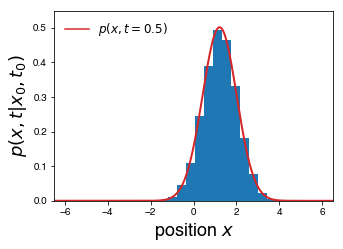

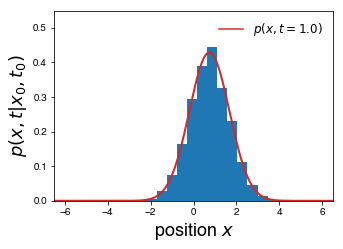

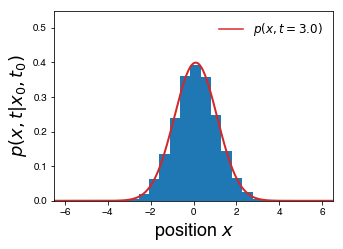

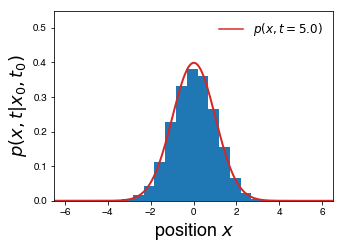

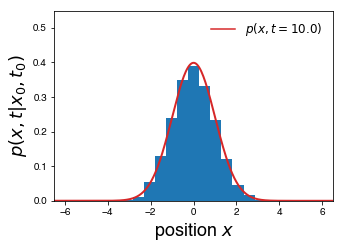

In [309]:
plotPositionPDF_harmonic(Xh[0, :], 0.5, x0 = x0)
plotPositionPDF_harmonic(Xh[1, :], 1.0, x0 = x0)
plotPositionPDF_harmonic(Xh[2, :], 3.0, x0 = x0)
plotPositionPDF_harmonic(Xh[3, :], 5.0, x0 = x0)
plotPositionPDF_harmonic(Xh[4, :], 10.0, x0 = x0)

In [310]:
# compute the first moments and the MSD for the trajectories stored in Xh2
muh, MSDh = getMoments(Xh)

In [311]:
def plotFirstMomentsOU(X, Y, x0 = 0.0):
    ''' first moment of a Ornstein-Uhlenbeck process'''
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)
    
    ax.set_xlabel('time $t$', fontsize = 18)
    ax.set_ylabel(r'first moment $\langle x \rangle(t)$', fontsize = 18)
    labelfontsize = 15.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
        
    ax.plot([-2.0, 12.0], [0.0, 0.0], 
            dashes = [8.0, 5.0], 
            lw = 0.5, 
            color = 'k')
    
    xVals = np.linspace(0.0, 12.5, 500)
    yVals = np.array([x0 * np.exp(-t) for t in xVals])
    ax.plot(xVals, yVals, lw = 1.0, color = 'C0', 
            label = r'$\langle x\rangle(t) = x_0e^{-t}$')
    
    ax.scatter(X, Y, 
               color = 'k', 
               s = 45, 
               label = r'BD (numeric)')

    ax.set_xlim(-0.5, 11.2)
    ax.set_ylim(-0.32, 1.55)
    
    leg = ax.legend(scatterpoints = 1,
                     markerscale = 1.0,
                     ncol = 1,
                     fontsize = 18)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    return None

def plotMSD_harmonic(X, Y, D = 1.0):
    
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)
    
    ax.set_xlabel('time $t$', fontsize = 18)
    ax.set_ylabel(r'MSD(t)', fontsize = 18)
    labelfontsize = 15.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
        
        
    xVals = np.linspace(0.0, 12.0, 500)
    yVals = np.array([D * (1.0 - np.exp(-2.0 * t)) for t in xVals])
        
    ax.plot(xVals, yVals, lw = 1.0, color = 'C3', 
            label = r'MSD(t) $= D(1-e^{-2t})$')
    ax.scatter(X, Y, color = 'k', s = 45, label = r'BD (numeric)')

    ax.set_xlim(0.0, 10.75)
    ax.set_ylim(0.0, 1.25)
    
    leg = ax.legend(loc = 'lower right',
                    scatterpoints = 1,
                    markerscale = 1.0,
                    ncol = 1,
                    fontsize = 18)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    return None

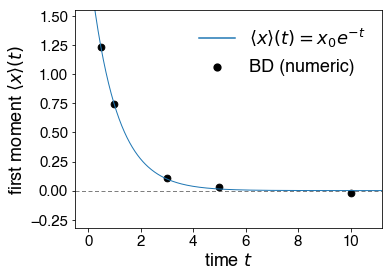

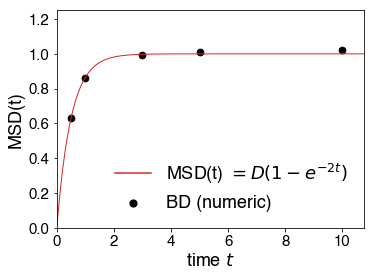

In [312]:
plotFirstMomentsOU(sampleTimes, muh, x0 = 2.0)
plotMSD_harmonic(sampleTimes, MSDh, D = 1.0)

## Analyze the accuracy of $p(x,t)$ for free diffusion as a function of the time step $\Delta t$

In [313]:
# set simulation parameters here
D = 1.0
x0 = 2.0
sampleTimes = np.array([3.0])
m = 10000

In [314]:
%%time
X1 = LangevinPropagator_vectorized(sampleTimes = sampleTimes, 
                                   m = m,
                                   x0 = x0,
                                   dt = 1.0)
X2 = LangevinPropagator_vectorized(sampleTimes = sampleTimes, 
                                   m = m,
                                   x0 = x0,
                                   dt = 0.1)
X3 = LangevinPropagator_vectorized(sampleTimes = sampleTimes, 
                                   m = m,
                                   x0 = x0,
                                   dt = 0.01)
X4 = LangevinPropagator_vectorized(sampleTimes = sampleTimes, 
                                   m = m,
                                   x0 = x0,
                                   dt = 0.001)
print(X1.shape)
print(X2.shape)
print(X3.shape)
print(X4.shape)

(1, 10000)
(1, 10000)
(1, 10000)
(1, 10000)
CPU times: user 2.04 s, sys: 29.5 ms, total: 2.07 s
Wall time: 2.15 s


In [315]:
def plot_PDF_free_mk2(X, t, label, x0 = 0.0, D = 1.0,):
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)

    labelfontsize = 10.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    
    counts, bins = np.histogram(X, bins = 40, normed = True)
    binCenters = [0.5 * (bins[k] + bins[k+1]) for k in range(len(counts))]
    binWidth = bins[1] - bins[0]
    ax.scatter(binCenters, counts,
                    s = 40.0,
                    marker = 'o',
                    facecolors = 'None',
                    edgecolors = 'k',
                    linewidth = 0.75,
                    label = label,
                    zorder = 3)
    
    xVals = np.linspace(-12.0, 12.0, 500)
    yVals = stats.norm.pdf(xVals, x0, np.sqrt(2.0 * D * t))
    labelString = r'$p(x,t = %.1f)$' %(t)
    ax.plot(xVals, yVals, lw = 1.0, color = 'k', label = labelString)
    
    ax.set_xlabel('position $x$', fontsize = 18)
    ax.set_ylabel(r'$p(x,t|x_0, t_0)$', fontsize = 18)
    
    ax.set_xlim(-6.25, 10.25)
    ax.set_ylim(0.0, 0.21)

    leg = ax.legend(fontsize = 12)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    
    return None

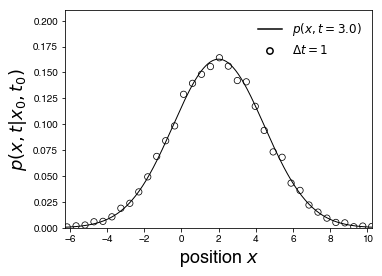

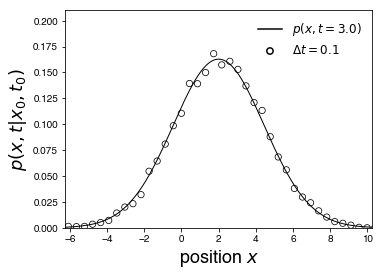

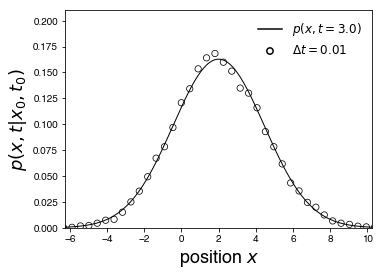

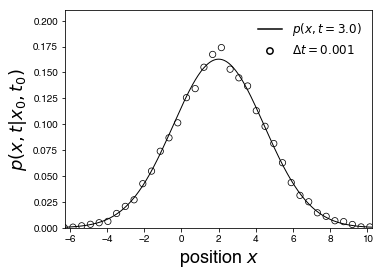

In [273]:
plot_PDF_free_mk2(X1, t = 3.0, label = r'$\Delta t = 1$', x0 = x0)
plot_PDF_free_mk2(X2, t = 3.0, label = r'$\Delta t = 0.1$', x0 = x0)
plot_PDF_free_mk2(X3, t = 3.0, label = r'$\Delta t = 0.01$', x0 = x0)
plot_PDF_free_mk2(X4, t = 3.0, label = r'$\Delta t = 0.001$', x0 = x0)

## Analyze the accuracy of $p(x,t)$ for diffusion in a harmonic potential as a function of the time step $\Delta t$

In [316]:
# set simulation parameters here
D = 1.0
x0 = 2.0
sampleTimes = np.array([3.0])
m = 10000

In [317]:
%%time
Xh1 = LangevinPropagator_vectorized(sampleTimes = sampleTimes, 
                                    m = m,
                                    a = -1.0,
                                    sigma = 1.0,
                                    dt = 1.0,
                                    x0 = x0)

Xh2 = LangevinPropagator_vectorized(sampleTimes = sampleTimes, 
                                    m = m,
                                    a = -1.0,
                                    sigma = 1.0,
                                    dt = 0.1,
                                    x0 = x0)

Xh3 = LangevinPropagator_vectorized(sampleTimes = sampleTimes, 
                                    m = m,
                                    a = -1.0,
                                    sigma = 1.0,
                                    dt = 0.01,
                                    x0 = x0)

Xh4 = LangevinPropagator_vectorized(sampleTimes = sampleTimes, 
                                    m = m,
                                    a = -1.0,
                                    sigma = 1.0,
                                    dt = 0.001,
                                    x0 = x0)

print(Xh1.shape)
print(Xh2.shape)
print(Xh3.shape)
print(Xh4.shape)

(1, 10000)
(1, 10000)
(1, 10000)
(1, 10000)
CPU times: user 1.9 s, sys: 21.6 ms, total: 1.92 s
Wall time: 2 s


In [318]:
def plot_PDF_harmonic_mk2(X, t, label, x0 = 0.0, D = 1.0,):
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)

    labelfontsize = 10.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    
    counts, bins = np.histogram(X, bins = 40, normed = True)
    binCenters = [0.5 * (bins[k] + bins[k+1]) for k in range(len(counts))]
    binWidth = bins[1] - bins[0]
    ax.scatter(binCenters, counts,
                    s = 40.0,
                    marker = 'o',
                    facecolors = 'None',
                    edgecolors = 'k',
                    linewidth = 0.75,
                    label = label,
                    zorder = 3)
    
    xVals = np.linspace(-12.0, 12.0, 500)
    yVals = stats.norm.pdf(xVals, \
        x0 * np.exp(-t), np.sqrt(D * (1.0 - np.exp(-2.0 * t))))
    labelString = r'$p(x,t = %.1f)$' %(t)
    ax.plot(xVals, yVals, lw = 1.0, color = 'k', label = labelString)
    
    ax.set_xlabel('position $x$', fontsize = 18)
    ax.set_ylabel(r'$p(x,t|x_0, t_0)$', fontsize = 18)
    
    ax.set_xlim(-4.25, 4.25)
    ax.set_ylim(0.0, 0.435)

    leg = ax.legend(fontsize = 12)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    
    return None

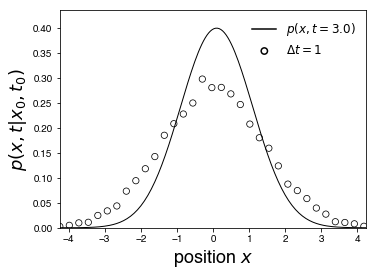

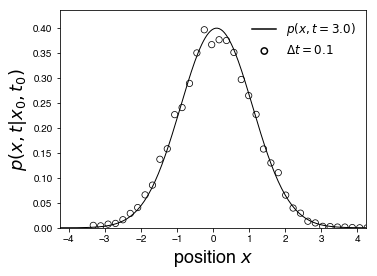

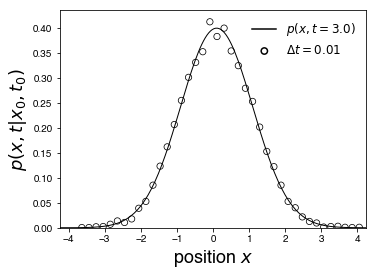

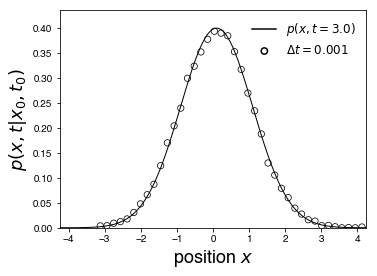

In [319]:
plot_PDF_harmonic_mk2(Xh1, t = 3.0, label = r'$\Delta t = 1$', x0 = x0)
plot_PDF_harmonic_mk2(Xh2, t = 3.0, label = r'$\Delta t = 0.1$', x0 = x0)
plot_PDF_harmonic_mk2(Xh3, t = 3.0, label = r'$\Delta t = 0.01$', x0 = x0)
plot_PDF_harmonic_mk2(Xh4, t = 3.0, label = r'$\Delta t = 0.001$', x0 = x0)